<a href="https://colab.research.google.com/github/SevilayMuni/Flask-App-Roberta-Detect-News/blob/main/RoBERTa-Unreliable-News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuned ROBERTA Model for Detecting Unreliable News

## Prepare Coding Environment

*   Installation
*   Importing Libraries
*   Disabling Weights & Biases (W&B)
*   Setting Random Seed





In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Setting random seeds for reproducible results
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
import re

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

**Note on dataset**  
**train.csv**: A full training dataset with the following attributes:

id: unique id for a news article
title: the title of a news article
author: author of the news article
text: the text of the article; could be incomplete
label: a label that marks the article as potentially unreliable  
1: unreliable  
0: reliable

## Data Loading and Preprocessing

In [ ]:
# Load data from .csv file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP-projects/train.csv',
                 index_col = 'id')
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df.tail()

,title,author,text,label
id,,,,
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [ ]:
# Check the df shape
df.shape

(20800, 4)

### Removing Special Characters from Text

In [ ]:
# Define function to clean string input from special characters
# It will reduce the noise
def clean_text(text):
    """
    Cleans text by removing special characters, URLs, and extra whitespace.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove special characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
# Create new column including both title and text input
df["content"] = df["title"] + " " + df["text"]
# Apply cleaning function
df["content"] = df["content"].astype(str).apply(clean_text)
# Subselect the dataframe
df_2 = df[["content", "label"]]
df_2.head()

,content,label
id,,
0,House Dem Aide We Didnt Even See Comeys Letter...,1
1,FLYNN Hillary Clinton Big Woman on Campus Brei...,0
2,Why the Truth Might Get You Fired Why the Trut...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


### Removing Duplicates

In [ ]:
# Drop duplicates from the original dataset
df_2 = df_2.drop_duplicates(subset = 'content').reset_index(drop = True)

In [ ]:
# Check the df shape after removing duplicates
df_2.shape

(20122, 2)

### Visualization of Class Distributions

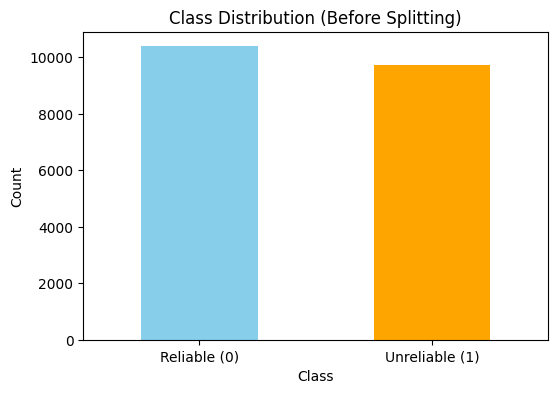

In [ ]:
# Visualize class distribution in the entire dataset before splitting:
# Count class instances
class_counts = df_2['label'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
class_counts.plot(kind = 'bar', color = ['skyblue', 'orange'])
plt.title('Class Distribution (Before Splitting)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1],
           labels = ['Reliable (0)', 'Unreliable (1)'], rotation = 0)
plt.show()

### Train/Test Split

In [ ]:
# Split dataset into training and testing
train_X, val_X, train_y, val_y = train_test_split(df_2["content"].tolist(),
                                                  df_2["label"].tolist(),
                                                  test_size = 0.2,
                                                  random_state = 27)

# Check the dataset shapes
print(f"Train dataset shape: {len(train_X)}")
print(f"Test dataset shape: {len(val_X)}")
print(f"Train label shape: {len(train_y)}")
print(f"Test label shape: {len(val_y)}")

### Ensuring No Overlap btw Sets

In [ ]:
# Ensure no overlap between training and validation datasets
train_set = set(train_X)  # Convert training data to a set
val_set = set(val_X)      # Convert validation data to a set

# Find intersection
overlap = train_set.intersection(val_set)

# Print results
if len(overlap) > 0:
    print(f"Overlap found: {len(overlap)} samples")
else:
    print("No overlap between training and validation datasets.")

No overlap between training and validation datasets.


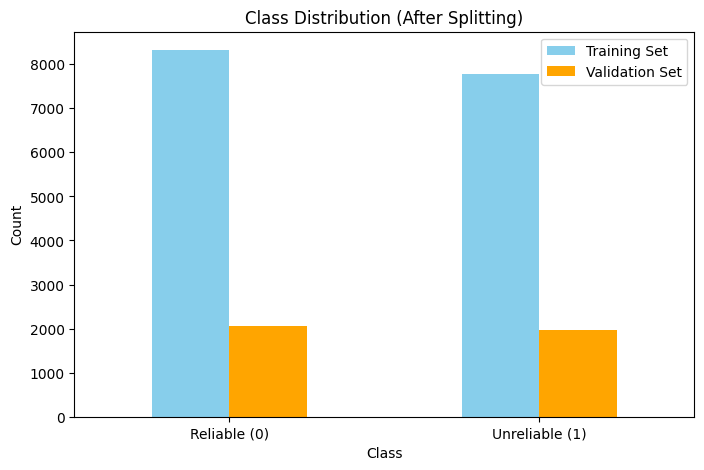

In [ ]:
# Visualize class distribution in training and validation datasets
# Count instances for each set
train_class_counts = pd.Series(train_y).value_counts()
val_class_counts = pd.Series(val_y).value_counts()

# Combine into a DataFrame
class_distribution = pd.DataFrame({
    'Training Set': train_class_counts,
    'Validation Set': val_class_counts
}).fillna(0)

# Plot
class_distribution.plot(kind = 'bar', figsize = (8, 5),
                        color = ['skyblue', 'orange'])
plt.title('Class Distribution (After Splitting)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1],
           labels = ['Reliable (0)', 'Unreliable (1)'], rotation = 0)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Ensure proper types for train and validation data
train_X = [str(text) for text in train_X]
val_X = [str(text) for text in val_X]
train_y = [int(label) for label in train_y]
val_y = [int(label) for label in val_y]

### Data Tokenization

In [ ]:
# Tokenize The Data
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize_function(examples):
    return tokenizer(examples["content"],
                     padding = "max_length",
                     truncation = True,
                     max_length = 512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Creating Dataset as Torch

In [ ]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"content": train_X,
                                   "label": train_y})
val_dataset = Dataset.from_dict({"content": val_X,
                                 "label": val_y})

train_dataset = train_dataset.map(tokenize_function,
                                  batched = True)
val_dataset = val_dataset.map(tokenize_function,
                              batched = True)

train_dataset = train_dataset.remove_columns(["content"])
val_dataset = val_dataset.remove_columns(["content"])

train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/16097 [00:00<?, ? examples/s]

Map:   0%|          | 0/4025 [00:00<?, ? examples/s]

## Model Fine-Tuning

### Load Roberta Base Model

In [ ]:
# Load pre-trained model
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                         num_labels = 2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining Training Parameters

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir = "./results2",
    eval_strategy = "epoch",
    save_strategy = "no",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 2,
    weight_decay = 0.01,
    logging_dir = "./logs",
    logging_steps = 10,
    save_total_limit = 2,
    report_to = [])

### Function For Performance Metrics

In [ ]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": acc, "f1": f1}

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics)

<ipython-input-20-17f21cefcee6>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train The Model

In [ ]:
# Fine-tune model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.184200,0.034083,0.992547,0.992363
2,0.000100,0.041286,0.993540,0.993357


TrainOutput(global_step=2014, training_loss=0.05559747198363882, metrics={'train_runtime': 3322.7503, 'train_samples_per_second': 9.689, 'train_steps_per_second': 0.606, 'total_flos': 8470597316259840.0, 'train_loss': 0.05559747198363882, 'epoch': 2.0})

## Model Evaluation

In [ ]:
# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.041285715997219086, 'eval_accuracy': 0.9935403726708074, 'eval_f1': 0.9933571793561574, 'eval_runtime': 120.3303, 'eval_samples_per_second': 33.45, 'eval_steps_per_second': 2.094, 'epoch': 2.0}


### Training Loss & Accuracy Plots

In [ ]:
# Plot training loss and evaluation metrics
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
epochs = range(1, len(train_loss) + 1)

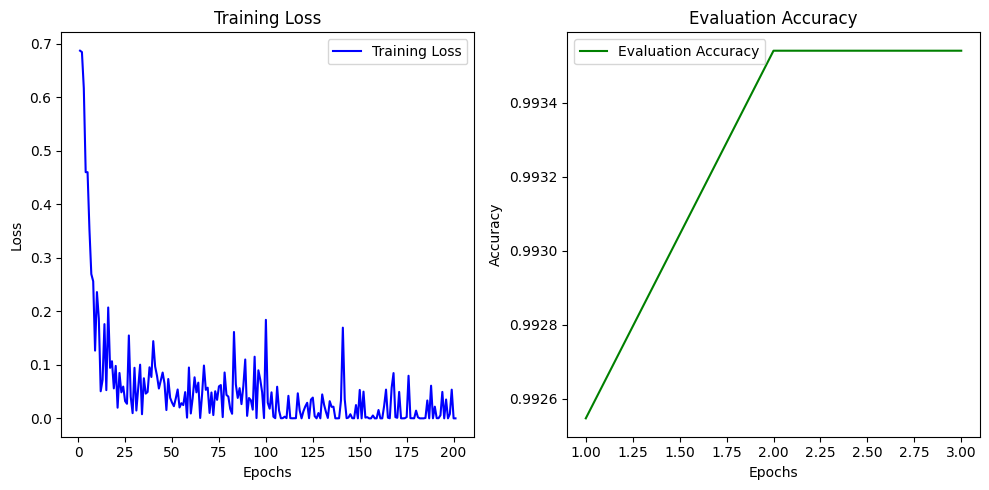

In [ ]:
# Separate plots for training loss and evaluation accuracy
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Training Loss
axes[0].plot(epochs, train_loss, label = "Training Loss", color = "blue")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].legend()

# Evaluation Accuracy
eval_epochs = range(1, len(eval_accuracy) + 1)
axes[1].plot(eval_epochs, eval_accuracy,
             label = "Evaluation Accuracy", color = "green")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Evaluation Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

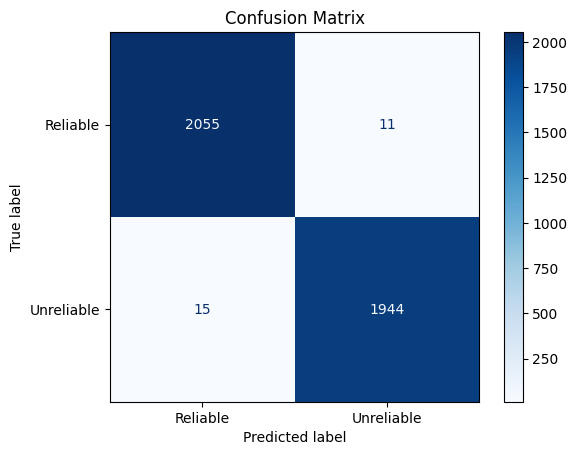

In [ ]:
# Confusion Matrix
predictions = trainer.predict(val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim = 1).numpy()
cm = confusion_matrix(val_y, preds)
ConfusionMatrixDisplay(cm, display_labels=["Reliable", "Unreliable"]).plot(cmap = "Blues")
plt.title("Confusion Matrix")
plt.show()

## Save Fine-Tuned Model and Its Tokenizer

In [ ]:
# Define a directory to save the model and tokenizer
output_dir = "/content/drive/MyDrive/Colab Notebooks/NLP-projects/roberta_model"

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved in: {output_dir}")

Model and tokenizer saved in: /content/drive/MyDrive/Colab Notebooks/NLP-projects/roberta_model
